Carrying the same basic concepts as notebook 1 and 2.


The key difference is we will keep 2D structure of images and use convolutions.

We found that POD modes are not the best reduction of the images since the extrapolation performance of the NODE is very poor. Instead, we flatten the full image and try to see if CNNs do any better.

In [1]:
import os
import scipy.signal
os.getcwd()

'/global/u1/a/ajivani/WLROM/WhiteLight'

In [2]:
current_dir = os.getcwd()

In [3]:
import numpy as np
from numpy import ogrid
import pandas as pd
import scipy.linalg as la
import scipy.sparse as sparse
import matplotlib.pyplot as plt

import copy

In [4]:
%matplotlib inline

In [5]:
import time

In [6]:
from sunpy.visualization import colormaps as cm

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

In [8]:
import argparse

In [99]:
parser = argparse.ArgumentParser()
parser.add_argument('--tol', type=float, default=1e-3)
parser.add_argument('--adjoint', type=eval, default=True, choices=[True, False])
parser.add_argument('--lr', type=float, default=0.1)
parser.add_argument('--debug', action='store_true')
parser.add_argument('-runCNN', type=eval, default=False, choices=[True, False])


args = parser.parse_args(args=())

In [100]:
args

Namespace(adjoint=True, debug=False, lr=0.1, runCNN=False, tol=0.001)

In [11]:
args.tol

0.001

In [12]:
# adjoint=True

In [13]:
!pip install --user torchdiffeq

In [14]:
if args.adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [16]:
device

device(type='cuda', index=0)

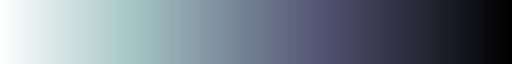

In [17]:
lc3 = cm.cmlist['soholasco3'].reversed()
lc3

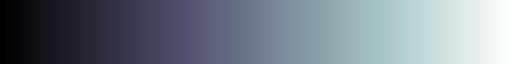

In [18]:
lc3_reg = cm.cmlist['soholasco3']
lc3_reg

In [19]:
plt.rc("axes.spines", right=True, top=True)
plt.rc("figure", dpi=300, 
       figsize=(9, 3)
      )
plt.rc("font", family="serif")
plt.rc("legend", edgecolor="none", frameon=True)
plt.style.use("dark_background")

In [20]:
import sys
# sys.path.insert(1, '/home/ajivani/WLROM/EdgeSS')
sys.path.insert(1, os.path.join(current_dir, "..", "EdgeSS"))

In [21]:
import edge_utils as edut

### Setup training and testing data

In [22]:
X_orig = np.load("./CR2161_tDecay2h_Polar_Compressed.npy")

In [23]:
X_orig.shape

(64, 256, 90, 278)

In [24]:
X = X_orig.reshape((64 * 256, 90, 278))[:, :, :]

In [25]:
X.shape

(16384, 90, 278)

In [26]:
sid=0

In [27]:
ed_2161, sd_2161 = edut.load_edge_data_blobfree(2161)

In [28]:
tMinIdx, tMin, tMaxIdx, tMax = edut.getTMinTMax(ed_2161, simIdx=sid)

In [29]:
tMinIdx

11

In [30]:
tMaxIdx

79

In [31]:
all_times = np.linspace(2, 180, 90)

In [32]:
valid_times = np.arange(tMin, tMax + 2, step=2)
valid_times

array([ 24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,  44.,
        46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,  66.,
        68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,  88.,
        90.,  92.,  94.,  96.,  98., 100., 102., 104., 106., 108., 110.,
       112., 114., 116., 118., 120., 122., 124., 126., 128., 130., 132.,
       134., 136., 138., 140., 142., 144., 146., 148., 150., 152., 154.,
       156., 158., 160.])

In [33]:
validTimeStartIdx = np.argwhere(all_times == valid_times[0])[0][0]
validTimeStartIdx

11

In [34]:
tTrainEnd = tMin + np.floor((2/3)*(tMax - tMin))
tTrainEnd

114.0

In [35]:
trainEndIdx = np.argwhere(valid_times == tTrainEnd)[0][0]
trainEndIdx

45

In [36]:
trainEndIdxAllTimes = np.argwhere(all_times == tTrainEnd)[0][0]
trainEndIdxAllTimes

56

In [37]:
all_times[(trainEndIdxAllTimes + 1):]

array([116., 118., 120., 122., 124., 126., 128., 130., 132., 134., 136.,
       138., 140., 142., 144., 146., 148., 150., 152., 154., 156., 158.,
       160., 162., 164., 166., 168., 170., 172., 174., 176., 178., 180.])

In [38]:
tTrain = valid_times[:(trainEndIdx + 1)]

In [39]:
tTrain

array([ 24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,  44.,
        46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,  66.,
        68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,  88.,
        90.,  92.,  94.,  96.,  98., 100., 102., 104., 106., 108., 110.,
       112., 114.])

In [40]:
tTest = valid_times[(trainEndIdx + 1):]
tTest

array([116., 118., 120., 122., 124., 126., 128., 130., 132., 134., 136.,
       138., 140., 142., 144., 146., 148., 150., 152., 154., 156., 158.,
       160.])

In [41]:
tTrainScaled = (tTrain - tMin) / (tMax - tMin)
tTestScaled = (tTest - tMin) / (tMax - tMin)

tAllScaled = (valid_times - tMin) / (tMax - tMin)

In [42]:
tAllScaled.shape

(69,)

In [43]:
nTrain = len(tTrain)
nTrain

46

In [44]:
# Slice data for a particular sID!

x_train_orig = X_orig[:, :, validTimeStartIdx:(trainEndIdxAllTimes + 1), sid]
x_train_orig = x_train_orig.transpose((2, 0, 1))

In [45]:
x_train_orig.shape

(46, 64, 256)

In [46]:
x_train_orig_torch = torch.from_numpy(np.expand_dims(np.float32(x_train_orig), axis=1)).to(device)
x_train_orig_torch.shape

torch.Size([46, 1, 64, 256])

In [47]:
x_orig_torch_full = X_orig[:, :, tMinIdx:(tMaxIdx + 1), sid]
x_orig_torch_full = x_orig_torch_full.transpose((2, 0, 1))
x_orig_torch_full = torch.from_numpy(np.expand_dims(np.float32(x_orig_torch_full), axis=1)).to(device)

x_orig_torch_full.shape

torch.Size([69, 1, 64, 256])

In [48]:
x_train_orig_torch[0][0].shape

torch.Size([64, 256])

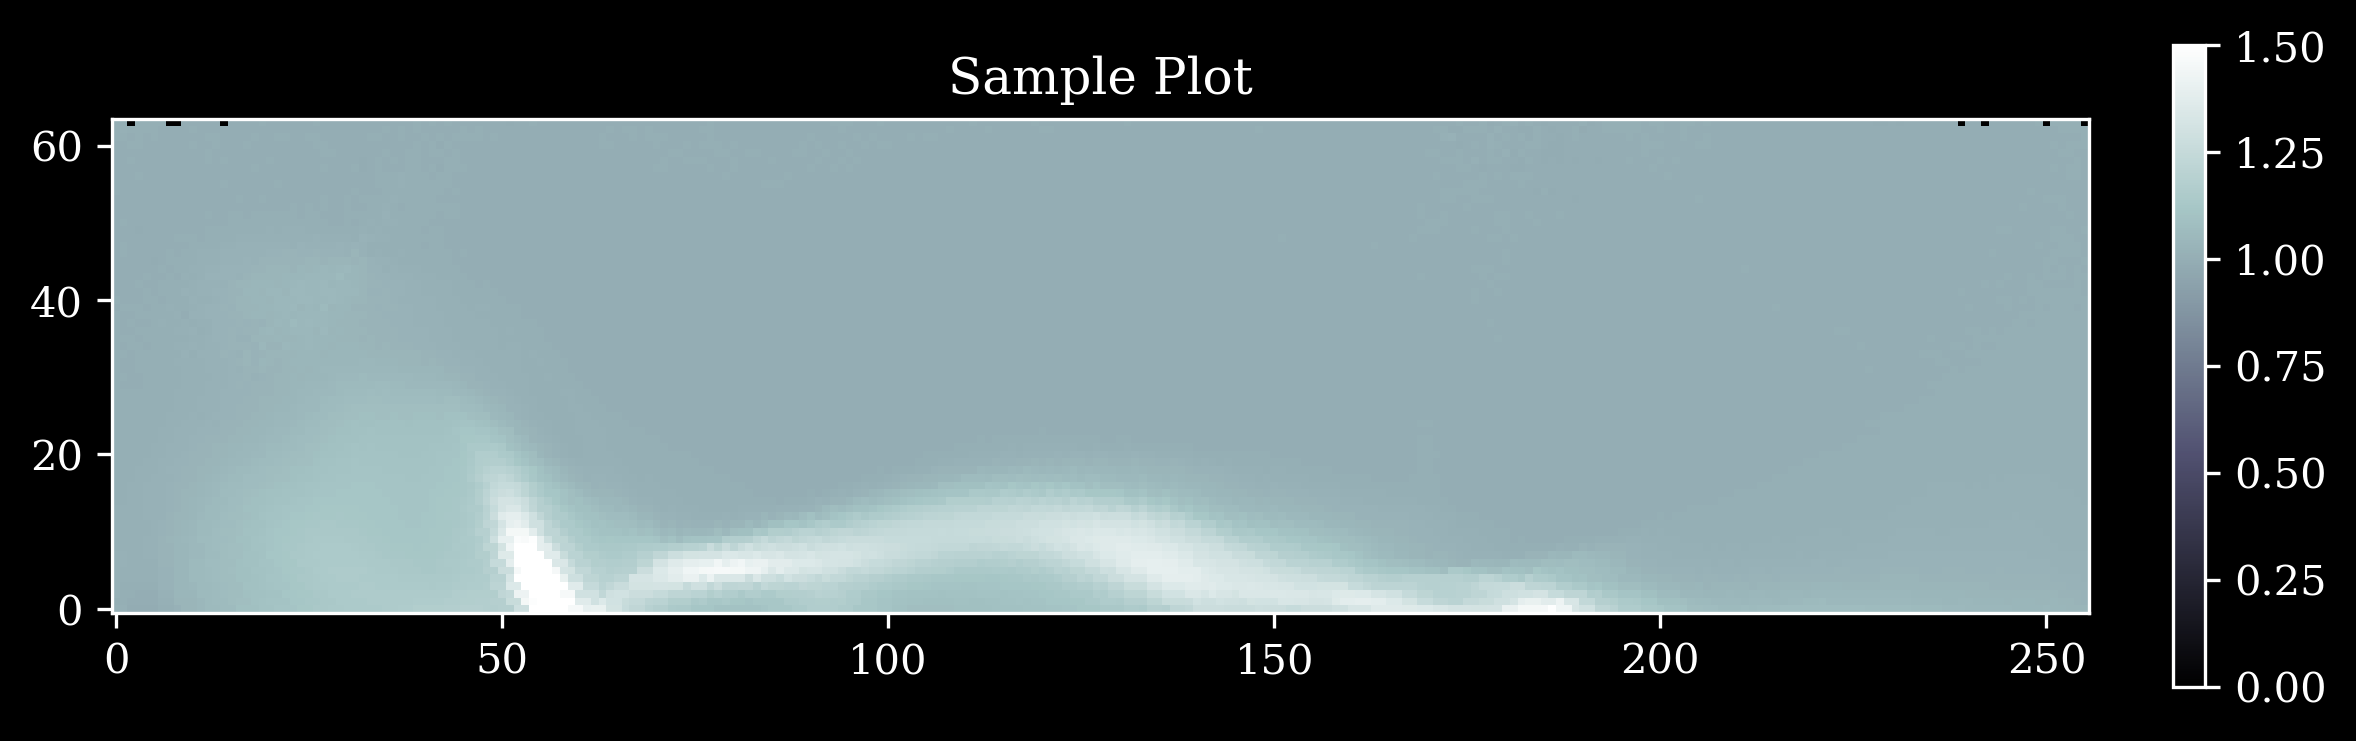

In [49]:
# plot and check to confirm right dimensions have been indexed?
plt.imshow(x_train_orig_torch[20][0].cpu(),
            origin="lower",
            cmap=lc3_reg)
plt.title("Sample Plot")
plt.colorbar(fraction=0.046 * 1/3, pad=0.04)

In [50]:
x_train_flat = X[:, validTimeStartIdx:(trainEndIdxAllTimes + 1), sid]
x_train_flat = x_train_flat.transpose((1, 0))
x_train_flat.shape

(46, 16384)

In [51]:
x_train_flat_torch = torch.from_numpy(np.expand_dims(np.float32(x_train_flat), axis=1)).to(device)
x_train_flat_torch.shape

torch.Size([46, 1, 16384])

In [52]:
x0_train_orig = x_train_orig[tMinIdx, :, :]
x0_train_orig.shape

(64, 256)

In [53]:
x0_train_orig_torch = torch.from_numpy(np.expand_dims(np.float32(x0_train_orig), axis=(0, 1))).to(device)
x0_train_orig_torch.shape

torch.Size([1, 1, 64, 256])

In [54]:
x0_train_flat = x0_train_orig.flatten()
x0_train_flat_torch = torch.from_numpy(np.float32(x0_train_flat)).reshape((1, len(x0_train_flat))).to(device)
x0_train_flat_torch.shape

torch.Size([1, 16384])

In [55]:
t_train_torch = torch.tensor(np.float32(tTrainScaled)).to(device)
t_train_torch.shape

torch.Size([46])

In [56]:
t_torch_full = torch.tensor(np.float32(tAllScaled)).to(device)

In [57]:
t_torch_full.shape

torch.Size([69])

In [58]:
data_size = t_train_torch.shape[0]
batch_time = 5
batch_size = 10

In [59]:
# VERIFIED THAT THIS WORKS PROPERLY
def get_batch(torch_train_data, torch_train_time, batch_time=5, batch_size=10):
    s = torch.from_numpy(np.random.choice(np.arange(len(torch_train_time) - batch_time, dtype=np.int64),
                                          batch_size,
                                          replace=False))
    batch_y0 = torch_train_data[s]
    batch_t = torch.zeros((batch_size, batch_time))
    for i in range(batch_size):
        batch_t[i, :] = torch_train_time[s[i]:(s[i] + batch_time)]
        
    batch_y = torch.stack([torch_train_data[s + i] for i in range(batch_time)], dim=0)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

In [60]:
# torch_train_data - x_train_orig_torch
# torch_train_time - t_train_torch

### Construction of CNN Architecture

In [61]:
class Flatten(nn.Module):

    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        return x.view(-1, shape)

In [62]:
class ConcatConv2d(nn.Module):

    def __init__(self, dim_in, dim_out, ksize=3, stride=1, padding=0, dilation=1, 
                 bias=True, transpose=False):
        super(ConcatConv2d, self).__init__()
        module = nn.ConvTranspose2d if transpose else nn.Conv2d
        self._layer = module(
            dim_in + 1, dim_out, kernel_size=ksize, 
            stride=stride, 
            padding=padding, 
            dilation=dilation, 
            bias=bias
        )

    def forward(self, t, x):
        tt = torch.ones_like(x[:, :1, :, :]) * t
        ttx = torch.cat([tt, x], 1)
        return self._layer(ttx)

In [63]:
def norm(dim):
    if dim == 1:
        return nn.GroupNorm(dim, dim)
    else:
        return nn.GroupNorm(min(8, dim), dim)

In [64]:
class ODEfunc(nn.Module):

    def __init__(self, dim):
        super(ODEfunc, self).__init__()
        self.norm1 = norm(dim)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = ConcatConv2d(dim, dim, 
                                  ksize=(3, 3),
                                  stride=(1, 1), 
                                  padding=(1, 1),
                                  dilation=(1, 1))
        self.norm2 = norm(dim)
        self.conv2 = ConcatConv2d(dim, dim, 
                                  ksize=(3, 3), 
                                  stride=(1, 1),
                                  padding=(1, 1), 
                                  dilation=(1, 1))
        self.norm3 = norm(dim)
        #         self.nfe = 0

    def forward(self, t, x):
        #         self.nfe += 1
        out = self.norm1(x)
        out = self.relu(out)
        out = self.conv1(t, out)
        out = self.norm2(out)
        out = self.relu(out)
        out = self.conv2(t, out)
        out = self.norm3(out)
        return out

Check downsampling with _all_ single channel convolutions v/s _some multi-channel convolutions_ in the middle (since the channel specification should not depend on padding etc., only the output width and height!)

In [65]:
class MyODEBlock(nn.Module):
    def __init__(self, dim, integration_time):
        super(MyODEBlock, self).__init__()
        
        self.dim = dim
        self.downsampling = [nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3, 3), 
                                       stride=(1, 1),
                                       padding=(1, 1),
                                       dilation=(1, 1)),
                            norm(1),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3, 3), 
                                       stride=(1, 1),
                                       padding=(1, 1),
                                       dilation=(1, 1)),
                            norm(1),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3, 3), 
                                       stride=(1, 1),
                                       padding=(1, 1),
                                       dilation=(1, 1))
                            ]
        
        
        self.odefunc = ODEfunc(self.dim)
        self.integration_time = integration_time


    def forward(self, x):
        #         #         t = t.reshape(1, 1)
        #         out = self.downsampling(x)
        #         out = self.odefunc(t, out)
        
        self.integration_time = self.integration_time.type_as(x)
        out = odeint(self.odefunc, x, self.integration_time, 
                     rtol=args.tol, atol=args.tol)
        
        #         out = self.fc_layers(out)
        return out

In [66]:
by0, bt, by = get_batch(x_train_orig_torch, t_train_torch)

In [67]:
by0.shape

torch.Size([10, 1, 64, 256])

In [68]:
bt

tensor([[0.0882, 0.1029, 0.1176, 0.1324, 0.1471],
        [0.0294, 0.0441, 0.0588, 0.0735, 0.0882],
        [0.0147, 0.0294, 0.0441, 0.0588, 0.0735],
        [0.2941, 0.3088, 0.3235, 0.3382, 0.3529],
        [0.3235, 0.3382, 0.3529, 0.3676, 0.3824],
        [0.2794, 0.2941, 0.3088, 0.3235, 0.3382],
        [0.4559, 0.4706, 0.4853, 0.5000, 0.5147],
        [0.5588, 0.5735, 0.5882, 0.6029, 0.6176],
        [0.5147, 0.5294, 0.5441, 0.5588, 0.5735],
        [0.1765, 0.1912, 0.2059, 0.2206, 0.2353]], device='cuda:0')

In [69]:
bt[0, :]

tensor([0.0882, 0.1029, 0.1176, 0.1324, 0.1471], device='cuda:0')

In [70]:
by.shape

torch.Size([5, 10, 1, 64, 256])

Pass `by0` through all dimensionality checks

In [71]:
downsampling_1 = nn.Sequential(nn.Conv2d(in_channels=1, 
                                         out_channels=1, 
                                         kernel_size=(3, 3), 
                                         stride=(1, 1),
                                         padding=(1, 1),
                                         dilation=(1, 1)),
                            norm(1),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(in_channels=1,
                                      out_channels=1,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=(1, 1),
                                      dilation=(1, 1)),
                            norm(1),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(in_channels=1,
                                      out_channels=1,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=(1, 1),
                                      dilation=(1, 1)),
                              ).to(device)

In [72]:
ds_1 = downsampling_1(by0)

In [73]:
ds_1.shape

torch.Size([10, 1, 64, 256])

Experiment with more channels in the downsampling stage?

In [74]:
downsampling_2 = nn.Sequential(nn.Conv2d(in_channels=1, 
                                         out_channels=16, 
                                         kernel_size=(3, 3), 
                                         stride=(1, 1),
                                         padding=(1, 1),
                                         dilation=(1, 1)),
                            norm(16),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(in_channels=16, 
                                      out_channels=16, 
                                      kernel_size=(3, 3), 
                                      stride=(1, 1),
                                      padding=(1, 1),
                                      dilation=(1, 1)),
                            norm(16),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(in_channels=16, 
                                      out_channels=1, 
                                      kernel_size=(3, 3), 
                                      stride=(1, 1),
                                      padding=(1, 1),
                                      dilation=(1, 1)),
                              ).to(device)

In [75]:
ds_2 = downsampling_2(by0)

In [76]:
ds_2.shape

torch.Size([10, 1, 64, 256])

More channels clearly works!

Next, we experiment with the `odeint` stuff in `MyODEBlock`. Note that here we pass a single row of times for the sake of checking dimensions / forward pass working but in reality we should pass full `bt` and do `odeint` individually over each row (don't know how inefficient this will be though)

In [77]:
my_model = MyODEBlock(1, bt[0, :]).to(device)

In [78]:
my_model(ds_1).shape

torch.Size([5, 10, 1, 64, 256])

In [79]:
ds_1[0].shape

torch.Size([1, 64, 256])

In [80]:
ds_1[[0]].shape

torch.Size([1, 1, 64, 256])

In [81]:
my_model(ds_1[[0]]).shape

torch.Size([5, 1, 1, 64, 256])

In [82]:
torch.squeeze(my_model(ds_1[[0]]), dim=1).shape

torch.Size([5, 1, 64, 256])

This works!!!

**Define Final Model and run experiments**

In [83]:
class ODEBlockCNN(nn.Module):
    """
    `dim` sets the dimension of the input channel that goes into the `conv` layers of `ODEfunc`. We keep it at 1
    `integration_time` is a 2D array of size `batch_size` x `batch_time` e.g 10x5. we want to take each row of the array and
    use that for `odeint` on every IC from our sequence.
    """
    def __init__(self, dim):
        super(ODEBlockCNN, self).__init__()
        
        self.dim = dim
        
        self.odefunc = ODEfunc(self.dim)
        
        self.downsampling = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), 
                                       stride=(1, 1),
                                       padding=(1, 1),
                                       dilation=(1, 1)),
                            norm(16),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), 
                                       stride=(1, 1),
                                       padding=(1, 1),
                                       dilation=(1, 1)),
                            norm(16),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(in_channels=16, out_channels=1, kernel_size=(3, 3), 
                                       stride=(1, 1),
                                       padding=(1, 1),
                                       dilation=(1, 1)))

    def forward(self, xt_list):
        x = xt_list[0]
        
        integration_time = xt_list[1].type_as(x)
        
        x = self.downsampling(x)
        
        if len(integration_time.shape) > 1:
            out = torch.cat([odeint(self.odefunc, x[[i]], integration_time[i, :], rtol=args.tol,
                                      atol=args.tol) for i in range(integration_time.shape[0])], dim=1)
        else:
            # print("Getting prediction for full series")
            out = odeint(self.odefunc, x, integration_time, rtol=args.tol,
                                      atol=args.tol)
            out = torch.squeeze(out, dim=1)

        
        return out

In [84]:
# my_cnn_model = ODEBlockCNN(1).to(device)

In [85]:
# by0.shape, bt.shape

In [86]:
# my_cnn_model.forward([by0, bt]).shape

In [87]:
x_orig_torch_full.shape

torch.Size([69, 1, 64, 256])

In [88]:
x_orig_torch_full[[0]].shape

torch.Size([1, 1, 64, 256])

In [89]:
len(x_orig_torch_full.shape)

4

In [90]:
len(t_torch_full.shape)

1

Set up final training loop for CNN

In [91]:
my_cnn_model = ODEBlockCNN(1).to(device)
optimizer = optim.Adam(my_cnn_model.parameters(), lr=1e-3)
end = time.time()

In [92]:
niters = 1000
test_freq = 5

In [93]:
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.losses = []
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val
        self.losses.append(self.avg)

In [94]:
time_meter = RunningAverageMeter(0.97)
loss_meter = RunningAverageMeter(0.97)

if args.runCNN:

    for itr in range(1, niters + 1):
        optimizer.zero_grad()

        batch_y0, batch_t, batch_y = get_batch(x_train_orig_torch, t_train_torch)

        pred_y = my_cnn_model([batch_y0, batch_t])

        loss = torch.mean(torch.abs(pred_y - batch_y))
        loss.backward()
        optimizer.step()

        #     step_loss.append(loss.item())

        time_meter.update(time.time() - end)
        loss_meter.update(loss.item())

        if itr % test_freq == 0:
            with torch.no_grad():
                pred_y_full_series = my_cnn_model([x_orig_torch_full[[0]], t_torch_full])
                loss_full_series = torch.mean(torch.abs(pred_y_full_series 
                                                        - x_orig_torch_full))
                print("Iter {:04d} | Total Loss {:.6f} ".format(itr,
                                                                loss_full_series.item(), 
                                                                ))
                # ii += 1

        end = time.time()

Iter 0005 | Total Loss 0.311825 
Iter 0010 | Total Loss 0.306769 
Iter 0015 | Total Loss 0.305913 
Iter 0020 | Total Loss 0.276116 
Iter 0025 | Total Loss 0.268125 
Iter 0030 | Total Loss 0.230864 
Iter 0035 | Total Loss 0.188590 
Iter 0040 | Total Loss 0.136043 
Iter 0045 | Total Loss 0.135765 
Iter 0050 | Total Loss 0.136156 
Iter 0055 | Total Loss 0.113791 
Iter 0060 | Total Loss 0.100342 
Iter 0065 | Total Loss 0.100172 
Iter 0070 | Total Loss 0.102878 
Iter 0075 | Total Loss 0.105360 
Iter 0080 | Total Loss 0.118608 
Iter 0085 | Total Loss 0.103994 
Iter 0090 | Total Loss 0.125952 
Iter 0095 | Total Loss 0.105566 
Iter 0100 | Total Loss 0.101200 
Iter 0105 | Total Loss 0.098005 
Iter 0110 | Total Loss 0.102859 
Iter 0115 | Total Loss 0.096660 
Iter 0120 | Total Loss 0.095880 
Iter 0125 | Total Loss 0.096538 
Iter 0130 | Total Loss 0.097703 
Iter 0135 | Total Loss 0.102479 
Iter 0140 | Total Loss 0.097468 
Iter 0145 | Total Loss 0.121976 
Iter 0150 | Total Loss 0.095086 
Iter 0155 

In [97]:
torch.save(my_cnn_model, "dy_dt_CNNy_1000_steps.pkl")

In [98]:
torch.save(optimizer, "dy_dt_CNNy_optim_1000_steps.pkl")

In [ ]:
if not args.runCNN:
    func_saved = torch.load("dy_dt_CNNy_1000_steps.pkl")
    optim_saved = torch.load("dy_dt_CNNy_optim_1000_steps.pkl")

In [104]:
with torch.no_grad():
    pred_y_final = my_cnn_model([x_orig_torch_full[[0]], t_torch_full]).cpu().numpy()[:, 0, :, :]

In [105]:
pred_y_final.shape

(69, 64, 256)

In [106]:
x_orig_full_cpu = x_orig_torch_full.cpu().numpy()[:, 0, :, :]

In [107]:
x_orig_full_cpu.shape

(69, 64, 256)

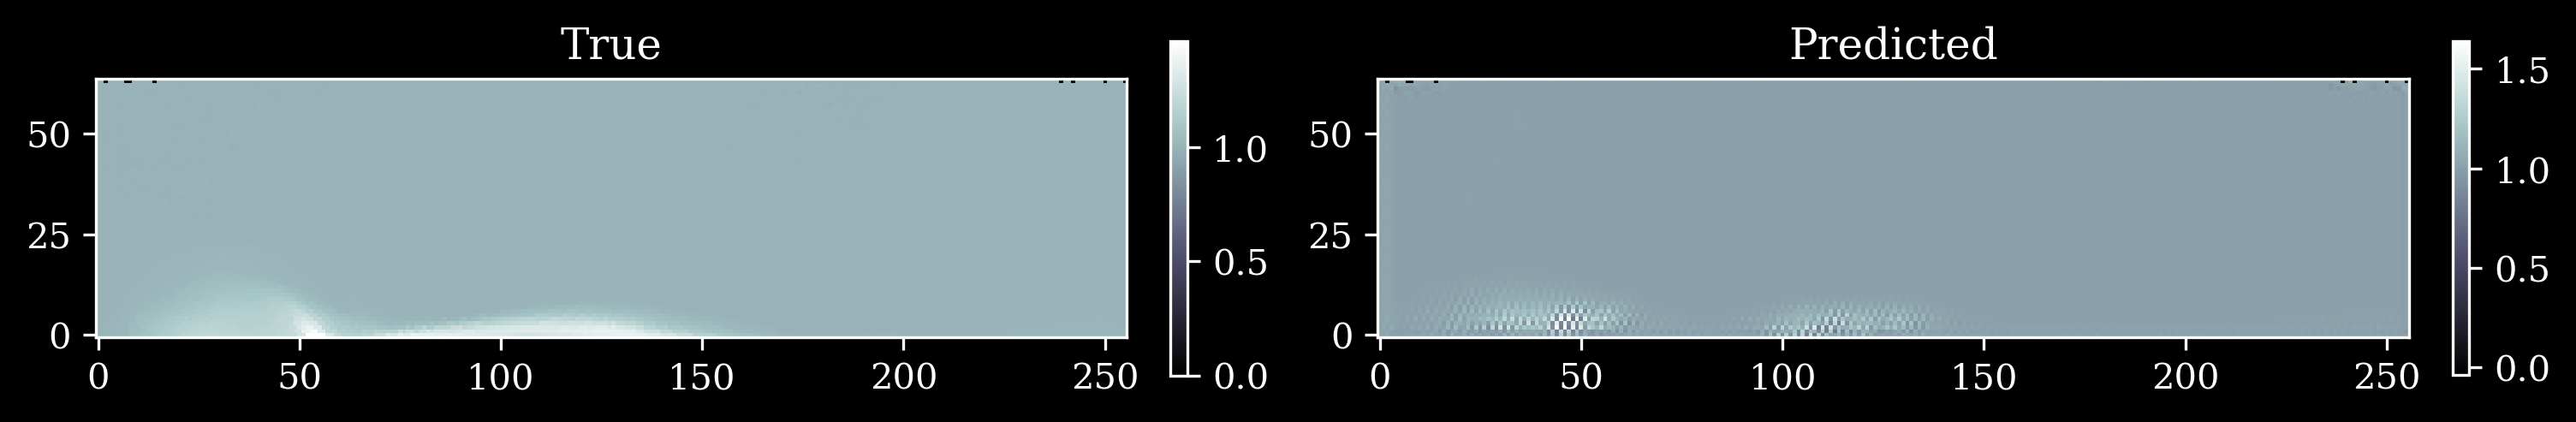

In [117]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
axs = ax.ravel()
im0 = axs[0].imshow(x_orig_full_cpu[6, :, :],
            origin="lower",
            cmap=lc3_reg)
axs[0].set_title("True")
fig.colorbar(im0, fraction=0.046 * 1/3, pad=0.04, ax=axs[0])

im1 = axs[1].imshow(pred_y_final[6, :, :],
                   origin="lower",
                   cmap=lc3_reg)
axs[1].set_title("Predicted")
fig.colorbar(im1, fraction=0.046 * 1/3, pad=0.04, ax=axs[1])
fig.tight_layout()

#### SCRATCH

**Helpful**

Downsample a stack of images in PyTorch:
https://gist.github.com/patrickmineault/21b8d78f423ac8ea4b006f9ec1a1a1a7


Clear batch from GPU memory after each iteration:
https://saturncloud.io/blog/how-to-clear-gpu-memory-after-pytorch-model-training-without-restarting-kernel/

https://stackoverflow.com/a/70541483

In [ ]:
# class ODEfuncTrial(nn.Module):
#     """
#     Trial and error for architecture of the ODEfunc with convolutions!
#     """
    
#     def __init__(self):
#         super(ODEfuncTrial, self).__init__()
        
#         self.conv1 = nn.Conv2d(in_channels=1,
#                              out_channels=1,
#                              kernel_size=3,
#                              stride=1,
#                              padding=1
#                               )
        
#         self.relu1 = nn.ReLU()
#         self.mp = nn.MaxPool2d(kernel_size=1)
        
#         self.norm1 = norm(1)
#         self.relu2 = nn.ReLU(inplace=True)
#         self.flat = nn.Flatten()
#         #         self.lin1 = nn.Linear(16384, 16384)
        
#     def forward(self, t, x):
#         out = self.conv1(x)
#         out = self.relu1(out)
#         out = self.mp(out)
#         out = self.norm1(out)
#         out = self.relu2(out)
#         out = self.flat(out)
#         #         out = self.lin1(out)
#         out = self.relu1(out)
        
#         return out

In [ ]:
torch.cat((my_model(ds_1[[0]]), my_model(ds_1[[0]])), dim=1).shape

In [ ]:
# define tensors
tens_1 = torch.Tensor([[[11, 12, 13], 
                       [14, 15, 16]],
                       [[1, 2, 3],
                        [4, 5, 6]]])
tens_2 = torch.Tensor([[[17, 18, 19], 
                       [20, 21, 22]],
                       [[-1, -2, -3],
                        [-4, -5, -6]]])

In [ ]:
tens_1[:, :, 2]

In [ ]:
torch.cat((tens_1, tens_2), dim=1)[:, :, 0]

In [ ]:
torch.cat([tens_1, tens_2], dim=1)[:, :, 0]

In [ ]:
torch.cat([tens_2, tens_1], dim=1)[:, :, 0]

In [ ]:
s = torch.from_numpy(np.random.choice(np.arange(41, dtype=np.int64), 10,
                                          replace=False))

In [ ]:
s

In [ ]:
x_train_orig_torch.shape

In [ ]:
x_batch_sample = x_train_orig_torch[torch.tensor([5, 14, 33])]

In [ ]:
ll = [x_train_orig_torch[s + i] for i in range(5)]

In [ ]:
ll[0].shape

In [ ]:
x_batch_sample.shape

In [ ]:
64 * 256

In [ ]:
torch.sum(x_batch_sample[0] == x_train_orig_torch[5])

In [ ]:
### PROBLEMATIC??? reinitialize model with every fresh batch of integration time - not good. don't make
### integration time part of the model attributes!!!!
# class ODEBlockCNN(nn.Module):
#     """
#     `dim` sets the dimension of the input channel that goes into the `conv` layers of `ODEfunc`. We keep it at 1
#     `integration_time` is a 2D array of size `batch_size` x `batch_time` e.g 10x5. we want to take each row of the array and
#     use that for `odeint` on every IC from our sequence.
#     """
#     def __init__(self, dim, integration_time):
#         super(ODEBlockCNN, self).__init__()
        
#         self.dim = dim
#         self.downsampling = [nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), 
#                                        stride=(1, 1),
#                                        padding=(1, 1),
#                                        dilation=(1, 1)),
#                             norm(16),
#                             nn.ReLU(inplace=True),
#                             nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), 
#                                        stride=(1, 1),
#                                        padding=(1, 1),
#                                        dilation=(1, 1)),
#                             norm(16),
#                             nn.ReLU(inplace=True),
#                             nn.Conv2d(in_channels=16, out_channels=1, kernel_size=(3, 3), 
#                                        stride=(1, 1),
#                                        padding=(1, 1),
#                                        dilation=(1, 1))
#                             ]
        
        
#         self.odefunc = ODEfunc(self.dim)
#         self.integration_time = integration_time
#         self.batch_size = self.integration_time.shape[0]
#         self.batch_time = self.integration_time.shape[1]
        

#     def forward(self, x):        
#         self.integration_time = self.integration_time.type_as(x)
        
#         out = torch.cat([odeint(self.odefunc, x[[i]], self.integration_time[i, :], rtol=args.tol,
#                                       atol=args.tol) for i in range(batch_size)], dim=1)
        
#         return out